## イベントマッチのブキ偏差値

In [21]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.EVENT
date_from = dt.date(2023, 6, 28)
date_to = date_from + dt.timedelta(days=1)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

In [23]:
event = battles["event"].value_counts().index[0]
battles["event"].value_counts()

Foggy Notion    4512
Name: event, dtype: int64

パワー不明バトル数: 1810


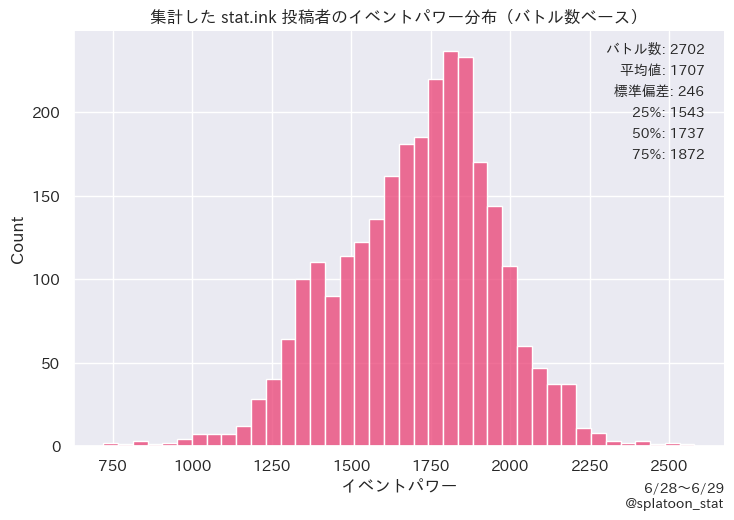

In [24]:
v.event_power_distribution(battles, locale)

In [25]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均イベントパワー

In [68]:
usage = players["weapon"].value_counts(normalize=True).to_frame(name="usage")
power = players.groupby("weapon")["power"].mean().to_frame(name="power")

def standardize(series: pd.Series) -> pd.Series:
    return (series - series.mean()) / series.std()

weapon_stat = pd.concat([usage, power], axis=1)
weapon_stat["usage-bc"] = boxcox(weapon_stat["usage"])[0]
weapon_stat["usage-z"] = standardize(weapon_stat["usage-bc"])
weapon_stat["power-z"] = standardize(weapon_stat["power"])

k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def calc_dot(series: pd.Series) -> float:
    vec_weapon = np.array([series["usage-z"], series["power-z"]])
    return np.dot(vec_weapon, vec_strength)

weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
# weapon_stat = weapon_stat[~weapon_stat["strength-t"].isna()]
weapon_stat

,usage,power,usage-bc,usage-z,power-z,strength,strength-z,strength-t
momiji,0.075830,1666.151244,-2.115157,2.405670,-0.957267,1.207591,1.291812,62.918120
sshooter_collabo,0.049202,1704.054420,-2.392333,1.913787,-0.231108,1.305163,1.398332,63.983318
promodeler_rg,0.045023,1625.737292,-2.446892,1.816966,-1.731528,0.257094,0.254150,52.541500
sharp_neo,0.040685,1707.050783,-2.508221,1.708130,-0.173702,1.186062,1.268308,62.683084
lact450,0.040084,1746.464413,-2.517156,1.692274,0.581395,1.664401,1.790514,67.905138
...,...,...,...,...,...,...,...,...
campingshelter,0.000728,1612.284615,-4.292028,-1.457446,-1.989258,-2.400171,-2.646800,23.532004
bucketslosher_deco,0.000697,1637.550000,-4.306044,-1.482318,-1.505217,-2.104724,-2.324259,26.757410
l3reelgun,0.000475,1779.412500,-4.422777,-1.689475,1.212623,-0.497151,-0.569263,44.307369
rpen_5h,0.000475,1750.016667,-4.422777,-1.689475,0.649450,-0.862903,-0.968556,40.314437


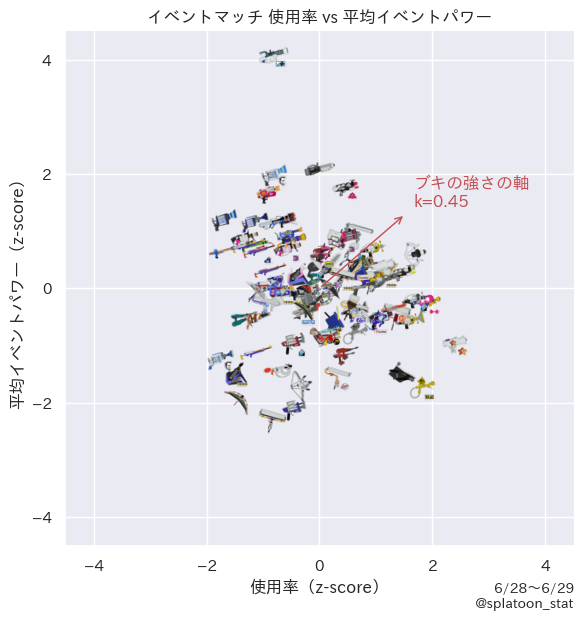

In [69]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均イベントパワー（z-score）", "Event Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均イベントパワー", "Usage vs Event Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    marker="",
    height=6,
)
ax = g.ax

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for _, row in weapon_stat.iterrows():
    weapon = row.name
    xvalue = row["usage-z"]
    yvalue = row["power-z"]
    image_path = image.get_image_path(weapon)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
    ax.add_artist(ab)

# ブキの強さの軸のベクトルを表示する
ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

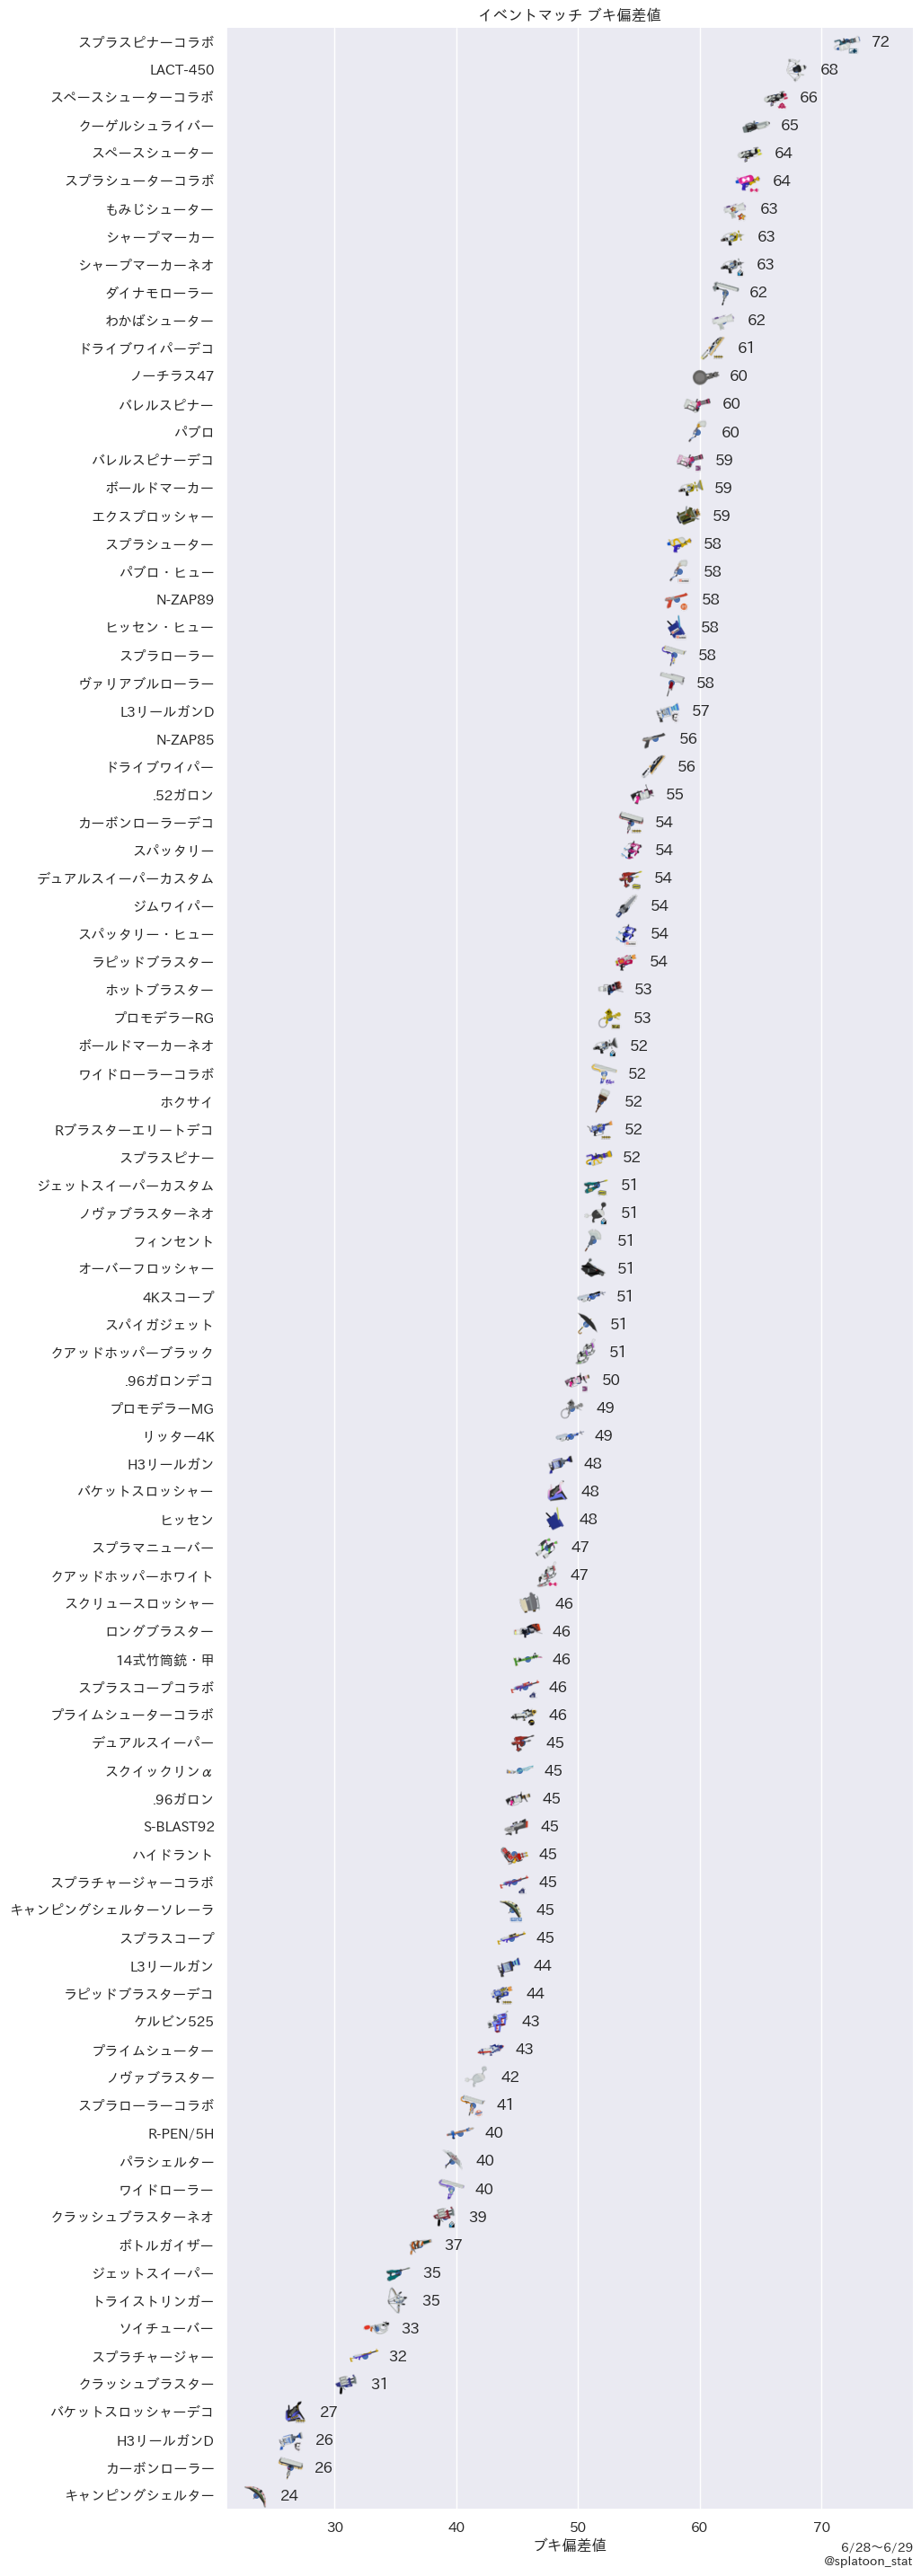

In [70]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")

df = weapon_stat.sort_values("strength-t", ascending=False).reset_index().rename(columns={"index": "weapon"})
width = 10
height = len(df) * 0.32

g = sns.catplot(
    data=df,
    x="strength-t",
    y="weapon",
    height=height,
    aspect=width / height,
)
ax = g.ax

xmin, xmax = ax.get_xlim()
xkeys, ykeys = u.get_ax_ticklabels(ax)
yvalues = df["strength-t"].to_list()
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel=i18n.t("strength"),
    ylabel="",
    yticks=ax.get_yticks(),
    yticklabels=yticklabels,
    xlim=(xmin, xmax + 3),
)

for i, (key, value) in enumerate(zip(ykeys, yvalues)):
    image_path = image.get_image_path(key)
    im = plt.imread(image_path)
    img = OffsetImage(im, zoom=0.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (50, 0), xybox=(value, i), frameon=False, pad=0)
    ax.add_artist(ab)

    ax.annotate(round(value), (value + 2, i), va="center")

u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()